<a href="https://colab.research.google.com/github/gioviat/spectrallearning/blob/main/SpettraleTesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log.csv", append=True)

from tensorflow.linalg import matmul as tmm

In [ ]:
class SpectralLayer(tf.keras.layers.Layer):

    def __init__(self, next_layer_dim, activation=None,
                 is_base_trainable=True, diag_trainable='all', init=tf.keras.initializers.GlorotUniform(),
                 is_bias=True):

        super(SpectralLayer, self).__init__()

        self.final_shape = next_layer_dim
        self.is_base_trainable = is_base_trainable
        self.diag_trainable = diag_trainable
        self.is_bias = is_bias
        self.initial = init

        if activation == 'relu':
            self.nonlinear = tf.nn.relu
        elif activation == 'sigmoid':
            self.nonlinear = tf.math.sigmoid
        elif activation == 'tanh':
            self.nonlinear = tf.math.tanh
        elif activation == 'softmax':
            self.nonlinear = tf.nn.softmax
        else:
            self.nonlinear = tf.identity

    def build(self, input_shape):
      
        self.in_shape = input_shape[1]

        autov_1 = np.random.uniform(-0.5, 0.5, [self.in_shape])
        autov_2 = np.random.uniform(-0.5, 0.5, [self.final_shape])

        if self.diag_trainable == 'all':
            self.eigval_1 = tf.Variable(autov_1, dtype=tf.float32)
            self.eigval_2 = tf.Variable(autov_2, dtype=tf.float32)
        elif self.diag_trainable == '1':
            self.eigval_1 = tf.Variable(autov_1, dtype=tf.float32)
            #self.eigval_2 = tf.constant(np.ones([self.final_shape]), dtype=tf.float32)
            self.eigval_2 = tf.constant(np.zeros([self.final_shape]), dtype=tf.float32)
        elif self.diag_trainable == '2':
            self.eigval_1 = tf.constant(np.zeros([self.in_shape]), dtype=tf.float32)
            #self.eigval_1 = tf.constant(np.ones([self.in_shape]), dtype=tf.float32)
            self.eigval_2 = tf.Variable(autov_2, dtype=tf.float32)
        else:
            print("Select which portion of the eigenvalues matrix you want to train")

        if self.initial is not None:
            w = self.initial(shape=(self.final_shape, self.in_shape)).numpy()
            init_base = np.zeros([self.final_shape, self.in_shape])
            for m in range(0, self.final_shape):
                for n in range(0, self.in_shape):
                    init_base[m, n] = w[m, n] / (autov_1[n] - autov_2[m])
        else:
            init_base = np.random.uniform(0.05, 0.1, [self.final_shape, self.in_shape])

        if self.is_base_trainable:
            self.base = tf.Variable(init_base, dtype=tf.float32)
        else:
            self.base = tf.constant(init_base, dtype=tf.float32)

        if self.is_bias:
            self.bias = tf.Variable(np.zeros([self.final_shape, 1]), trainable=True, dtype=tf.float32)
        else:
            self.bias = tf.constant(np.zeros([self.final_shape, 1]), dtype=tf.float32)

    def call(self, data, training=False, threshold = False):
        ##I dati arrivano come le righe della matrice data quindi vanno trasposti

        diagonal_1 = tf.reshape(tf.linalg.diag(self.eigval_1), [self.in_shape, self.in_shape])
        diagonal_2 = tf.reshape(tf.linalg.diag(self.eigval_2), [self.final_shape, self.final_shape])

        x = tmm(tmm(self.base, diagonal_1) - tmm(diagonal_2, self.base), tf.transpose(data)) + self.bias

        if self.nonlinear is not None:
            x = self.nonlinear(tf.transpose(x))
        return x

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 , x_test / 255.0

x_train.shape

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

flat_train = np.reshape(x_train,[x_train.shape[0],28*28]) #Tutto dataset
flat_test = np.reshape(x_test,[x_test.shape[0],28*28]) #Tutto testset

flat_val = np.reshape(x_val,[x_val.shape[0],28*28])

print(flat_train.shape)
print(flat_val.shape)

11493376/11490434 [==============================] - 0s 0us/step
(50000, 784)
(10000, 784)


In [ ]:
#Rete Spettrale
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28 * 28), dtype='float32'))
model.add(SpectralLayer(2000, activation='relu', is_base_trainable = False, diag_trainable='1'))
model.add(SpectralLayer(10, is_base_trainable = False, activation='softmax', diag_trainable='1'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)  # about 0.05  linear and 0.03 eigvalue/0.01eigvector for the non linear

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=False)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_layer_8 (SpectralLa (None, 2000)              2784      
_________________________________________________________________
spectral_layer_9 (SpectralLa (None, 10)                2010      
Total params: 4,794
Trainable params: 4,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 20

print("Fit model on training data")
history = model.fit(flat_train, y_train, batch_size=500, epochs=epochs, validation_data = (flat_val, y_val), verbose=1, callbacks=[csv_logger])

print("Evaluate on test data")
tested = model.evaluate(flat_test, y_test, batch_size=500, verbose=0)
print("Test loss, test accuracy:", tested)

Wsave = model.get_weights()

Fit model on training data
Epoch 1/20
100/100 [==============================] - 2s 12ms/step - loss: 380.3587 - accuracy: 0.5000 - val_loss: 5.9648 - val_accuracy: 0.8887
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 4.9963 - accuracy: 0.8980 - val_loss: 1.8461 - val_accuracy: 0.9308
Epoch 3/20
100/100 [==============================] - 1s 9ms/step - loss: 1.6564 - accuracy: 0.9360 - val_loss: 1.0690 - val_accuracy: 0.9452
Epoch 4/20
100/100 [==============================] - 1s 9ms/step - loss: 0.6540 - accuracy: 0.9578 - val_loss: 0.7757 - val_accuracy: 0.9471
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 0.4021 - accuracy: 0.9676 - val_loss: 0.6696 - val_accuracy: 0.9546
Epoch 6/20
100/100 [==============================] - 1s 9ms/step - loss: 0.2272 - accuracy: 0.9766 - val_loss: 0.5154 - val_accuracy: 0.9607
Epoch 7/20
100/100 [==============================] - 1s 9ms/step - loss: 0.1530 - accuracy: 0.9817 - val_loss: 0.4721

Seleziona il layer su cui effettuare il trimming: 0


  Removing the eigenvalues: 100%|██████████| 99/99 [00:08<00:00, 12.21it/s]


TypeError: ignored

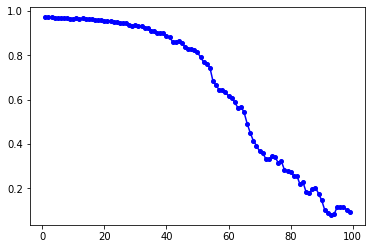

In [ ]:
# PRIMO TRIMMING, da 0 a 100 per plottare accuracy 

def trim_SL(model, layer = 0):
    """
    :param model: Modello da trimmare
    :param layer: su quale layer deve avvenire il trimming
    :return: accuracy in funzione del percentile dei pesi trimmati
    """
    #Carico il testset
    mnist = tf.keras.datasets.mnist

    _, (x_test, y_test) = mnist.load_data()
    x_test = x_test / 255.0
    flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])  # Tutto testset
    
    percentiles = np.arange(1, 100, 1)
    results = {"percentile": [], "val_loss": []}

    autov = model.layers[layer].eigval_1.numpy()
    abs_autov = abs(autov)
    thresholds = [np.percentile(abs_autov, q=perc) for perc in percentiles]
    for t, perc in tqdm(list(zip(thresholds, percentiles)), desc="  Removing the eigenvalues"):
        autov[abs_autov < t] = 0.0
        model.layers[layer].eigval_1.assign(autov)
        test_res = model.evaluate(flat_test, y_test, batch_size=1000, verbose=0)

        results["percentile"].append(perc)
        results["val_loss"].append(test_res[1])

    return [results["percentile"], results["val_loss"]]

#Trimm con funzione Trim_SL (Single Layer)
layer = int(input('Seleziona il layer su cui effettuare il trimming: '))
eigval_perc, acc_after_Trim = trim_SL(model, layer=layer)

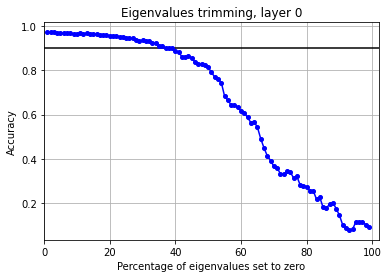

In [ ]:
plt.plot(eigval_perc, acc_after_Trim,'-bo',markersize=4)
plt.hlines(0.9,0,102)
plt.xlabel('Percentage of eigenvalues set to zero')
plt.ylabel('Accuracy')
plt.xlim(0,102)
plt.title('Eigenvalues trimming, layer %i' %layer)
plt.grid(True)
plt.show()

In [ ]:
  model.set_weights(Wsave)

  def trim_SL(model, layer = 0):
    """
    :param model: Modello da trimmare
    :param layer: su quale layer deve avvenire il trimming
    :return: accuracy in funzione del percentile dei pesi trimmati
    """
    #Carico il testset
    mnist = tf.keras.datasets.mnist

    _, (x_test, y_test) = mnist.load_data()
    x_test = x_test / 255.0
    flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])  # Tutto testset
    
    percentiles = np.arange(39, 40, 1)
    results = {"percentile": [], "val_loss": []}

    autov = model.layers[layer].eigval_1.numpy()
    abs_autov = abs(autov)
    thresholds = [np.percentile(abs_autov, q=perc) for perc in percentiles]
    for t, perc in tqdm(list(zip(thresholds, percentiles)), desc="  Removing the eigenvalues"):
        autov[abs_autov < t] = 0.0
        model.layers[layer].eigval_1.assign(autov)
        test_res = model.evaluate(flat_test, y_test, batch_size=1000, verbose=0)

        results["percentile"].append(perc)
        results["val_loss"].append(test_res[1])

    return [results["percentile"], results["val_loss"]]

In [ ]:
#SECONDO TRIMMING, per plottare l'intensità

#Trimm con funzione Trim_SL (Single Layer)
eigval_perc, acc_after_Trim = trim_SL(model, layer=layer)

autovalori = model.layers[0].eigval_1.numpy()
filter = np.ones(784)
filter[autovalori==0] = 0
a = flat_test*filter
a.shape
tested = model.evaluate(a, y_test, batch_size=1000, verbose=0)
print("Test loss, test accuracy:", tested)

  Removing the eigenvalues: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Test loss, test accuracy: [1.1840029954910278, 0.9240000247955322]


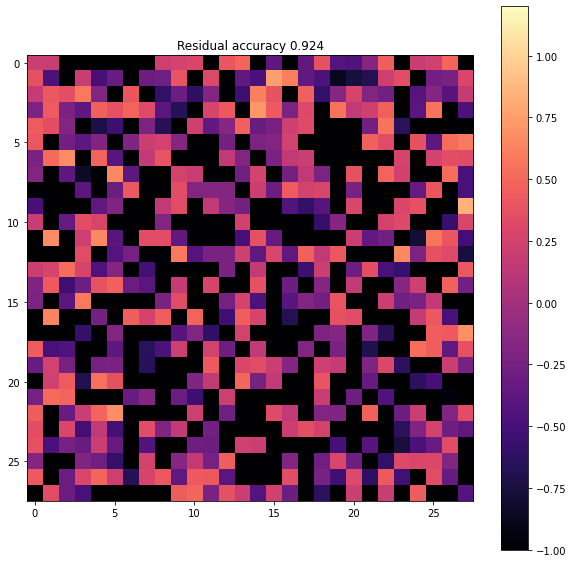

In [ ]:
autovalori = model.layers[0].eigval_1.numpy()
plt.figure(figsize=(10,10))
plt.title('Residual accuracy %.3f' %tested[1])
autovalori[autovalori==0] = -1 # questi sono i pixel non rilevanti; sono stati messi a -1 per il plot
matrix = np.reshape(autovalori,(28,28))
plt.imshow(matrix, cmap='magma', vmin=-1, vmax=1.2,
                             interpolation='none')
plt.colorbar()

In [ ]:
# Pandas
eigval_risultati =  pd.read_csv("eigval_model_history_log.csv")


eigval_risultati_per_epoca = []
eigval_acc = []
eigval_acc_std = []
eigval_loss = []
eigval_loss_std = []
eigval_val_acc = []
eigval_val_acc_std = []
eigval_val_loss = []
eigval_val_loss_std = []

eigval_accplus = []
eigval_accminus = []
eigval_lossplus = []
eigval_lossminus =[]
eigval_valaccplus = []
eigval_valaccminus =[]
eigval_vallossplus = []
eigval_vallossminus = []


for i in range(epochs):

  eigval_risultati_per_epoca.append(eigval_risultati[eigval_risultati["epoch"] == i])

  eigval_acc.append(eigval_risultati_per_epoca[i]["accuracy"].mean())
  eigval_loss.append(eigval_risultati_per_epoca[i]["loss"].mean())
  eigval_val_acc.append(eigval_risultati_per_epoca[i]["val_accuracy"].mean())
  eigval_val_loss.append(eigval_risultati_per_epoca[i]["val_loss"].mean())

  eigval_acc_std.append(eigval_risultati_per_epoca[i]["accuracy"].std())
  eigval_loss_std.append(eigval_risultati_per_epoca[i]["loss"].std())
  eigval_val_acc_std.append(eigval_risultati_per_epoca[i]["val_accuracy"].std())
  eigval_val_loss_std.append(eigval_risultati_per_epoca[i]["val_loss"].std())

  eigval_accplus.append(min(eigval_acc[i] + eigval_acc_std[i],1))
  eigval_accminus.append(eigval_acc[i] - eigval_acc_std[i])

  eigval_lossplus.append(eigval_loss[i] + eigval_loss_std[i])
  eigval_lossminus.append(max(eigval_loss[i] - eigval_loss_std[i],0))

  eigval_valaccplus.append(eigval_val_acc[i] + eigval_val_acc_std[i])
  eigval_valaccminus.append(eigval_val_acc[i] - eigval_val_acc_std[i])

  eigval_vallossplus.append(eigval_val_loss[i] + eigval_val_loss_std[i])
  eigval_vallossminus.append(eigval_val_loss[i] - eigval_val_loss_std[i])


eigval_results = pd.DataFrame(list(zip(eigval_acc, eigval_loss, eigval_val_acc, eigval_val_loss, eigval_accplus, eigval_accminus, eigval_lossplus, eigval_lossminus, eigval_valaccplus, eigval_valaccminus, eigval_vallossplus, eigval_vallossminus)), columns=['Mean_accuracy', 'Mean_loss', 'Mean_test_accuracy', 'Mean_test_loss', 'Accuracy_plus', 'Accuracy_minus', 'Loss_plus', 'Loss_minus', 'Val_acc_plus', 'Val_acc_minus', 'Val_loss_plus', 'Val_loss_minus'])
eigval_results.head()
eigval_results.to_csv(path_or_buf='eigval_results.csv')

print('Mean accuracy:', eigval_acc[i], 'err:', eigval_acc_std[i], '| Mean test accuracy:', eigval_val_acc[i], 'err:', eigval_val_acc_std[i], '\n')
print('Mean loss:', eigval_loss[i], 'err:', eigval_loss_std[i], '| Mean test accuracy:', eigval_val_loss[i], 'err:', eigval_val_loss_std[i], '\n')

Mean accuracy: 0.932818997502327 err: 0.0017155633656216172 | Mean test accuracy: 0.9311879974603653 err: 0.0032210565538166396 

Mean loss: 0.2251490432024002 err: 0.007192957502821493 | Mean test accuracy: 0.2454853820800781 err: 0.010725832971799725 



In [ ]:
# Pandas
risultati =  pd.read_csv("model_history_log.csv")


risultati_per_epoca = []
acc = []
acc_std = []
loss = []
loss_std = []
val_acc = []
val_acc_std = []
val_loss = []
val_loss_std = []

accplus = []
accminus = []
lossplus = []
lossminus =[]
valaccplus = []
valaccminus =[]
vallossplus = []
vallossminus = []


for i in range(epochs):

  risultati_per_epoca.append(risultati[risultati["epoch"] == i])

  acc.append(risultati_per_epoca[i]["accuracy"].mean())
  loss.append(risultati_per_epoca[i]["loss"].mean())
  val_acc.append(risultati_per_epoca[i]["val_accuracy"].mean())
  val_loss.append(risultati_per_epoca[i]["val_loss"].mean())

  acc_std.append(risultati_per_epoca[i]["accuracy"].std())
  loss_std.append(risultati_per_epoca[i]["loss"].std())
  val_acc_std.append(risultati_per_epoca[i]["val_accuracy"].std())
  val_loss_std.append(risultati_per_epoca[i]["val_loss"].std())

  accplus.append(min(acc[i] + acc_std[i],1))
  accminus.append(acc[i] - acc_std[i])

  lossplus.append(loss[i] + loss_std[i])
  lossminus.append(max(loss[i] - loss_std[i],0))

  valaccplus.append(val_acc[i] + val_acc_std[i])
  valaccminus.append(val_acc[i] - val_acc_std[i])

  vallossplus.append(val_loss[i] + val_loss_std[i])
  vallossminus.append(val_loss[i] - val_loss_std[i])


results = pd.DataFrame(list(zip(acc, loss, val_acc, val_loss, accplus, accminus, lossplus, lossminus, valaccplus, valaccminus, vallossplus, vallossminus)), columns=['Mean_accuracy', 'Mean_loss', 'Mean_test_accuracy', 'Mean_test_loss', 'Accuracy_plus', 'Accuracy_minus', 'Loss_plus', 'Loss_minus', 'Val_acc_plus', 'Val_acc_minus', 'Val_loss_plus', 'Val_loss_minus'])
results.head()
results.to_csv(path_or_buf='results.csv')

print('Mean accuracy:', acc[i], 'err:', acc_std[i], '| Mean test accuracy:', val_acc[i], 'err:', val_acc_std[i], '\n')
print('Mean loss:', loss[i], 'err:', loss_std[i], '| Mean test accuracy:', val_loss[i], 'err:', val_loss_std[i], '\n')

Mean accuracy: 0.9999207997322083 err: 0.0006358385198937383 | Mean test accuracy: 0.9717500001192093 err: 0.0009957982029666912 

Mean loss: 0.0006173948099603876 err: 0.004567387759636375 | Mean test accuracy: 0.2996146157383919 err: 0.0828907568755884 



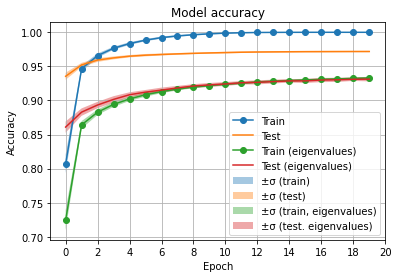

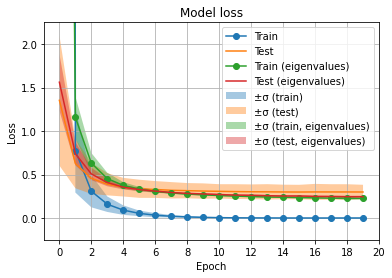

In [ ]:
# Grafici accuracy/loss
eigval_loss[0]=21.338
# list all data in history
x = []
for i in range(epochs):
    x.append(i)
    i+=1
# summarize history for accuracy
plt.plot(acc, linestyle = '-', marker = 'o')
plt.fill_between(x,accplus,accminus,alpha=0.4)
plt.plot(val_acc)
plt.fill_between(x,valaccplus,valaccminus,alpha=0.4)
plt.plot(eigval_acc, linestyle = '-', marker = 'o')
plt.fill_between(x,eigval_accplus,eigval_accminus,alpha=0.4)
plt.plot(eigval_val_acc)
plt.fill_between(x,eigval_valaccplus,eigval_valaccminus,alpha=0.4)
plt.title('Model accuracy')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.legend(['Train', 'Test', 'Train (eigenvalues)', 'Test (eigenvalues)', '±σ (train)', '±σ (test)', '±σ (train, eigenvalues)', '±σ (test. eigenvalues)'], loc='lower right')
plt.show()


axes = plt.gca()
  # summarize history for loss
plt.plot(loss, linestyle = '-', marker = 'o')
plt.fill_between(x,lossplus,lossminus,alpha=0.4)
plt.plot(val_loss)
plt.fill_between(x,vallossplus,vallossminus,alpha=0.4)
plt.plot(eigval_loss, linestyle = '-', marker = 'o')
plt.fill_between(x,eigval_lossplus,eigval_lossminus,alpha=0.4)
plt.plot(eigval_val_loss)
plt.fill_between(x,eigval_vallossplus,eigval_vallossminus,alpha=0.4)
axes.set_ylim([-0.25,2.25])

plt.title('Model loss')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.legend(['Train', 'Test', 'Train (eigenvalues)', 'Test (eigenvalues)', '±σ (train)', '±σ (test)', '±σ (train, eigenvalues)', '±σ (test, eigenvalues)'], loc='upper right')
plt.show()